In [1]:
import os
import numpy as np
from tqdm import tqdm
import pickle
import networkx as nx
from itertools import chain
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec
from collections import defaultdict
from mpl_toolkits import mplot3d
from matplotlib.patches import Circle
from mpl_toolkits.mplot3d import art3d
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap

from model.attackerbase import _read_matrix, _read_vector, _read_scalar
from simulation.normal_system import System
from model.attack_graph import get_points


In [2]:
DATA_PATH = os.path.join(os.getcwd(), 'data')
OUT_PATH = os.path.join(os.getcwd(), 'result')

In [3]:
def z_tau(x, tau, sd_s, lamb, kappa, gamma):
    denom = sd_s * np.sqrt(tau)
    sum_x = np.sum(x[:,1:tau+1], axis=1)
    nom = lamb - (kappa * tau) - np.dot(gamma, sum_x).item()
    return nom / denom

## **Attack graph topologies**

In [4]:
cl = dict()
f = dict()
h = dict()
experiments = ['type1', 'type2', 'type3', 'case']
for experiment_name in experiments:
    if experiment_name.startswith('type'):
        t = 400
        k = 3
        ag_path = os.path.join(DATA_PATH,'random', f'cl-{experiment_name}.pkl')
        result_path = os.path.join(OUT_PATH, 'random', experiment_name, f'T{t}-K{k}')
    else:
        t = 400
        k = 4
        ag_path = os.path.join(DATA_PATH, 'case', 'cl.pkl')
        result_path = os.path.join(OUT_PATH, 'case', f'T{t}-K{k}')
    with open(ag_path, 'rb') as fl:
        cl[experiment_name] = pickle.load(fl)
    with open(os.path.join(result_path, 'f.pkl'), 'rb') as fl:
        f[experiment_name] = pickle.load(fl)
    with open(os.path.join(result_path, 'h.pkl'), 'rb') as fl:
        h[experiment_name] = pickle.load(fl)

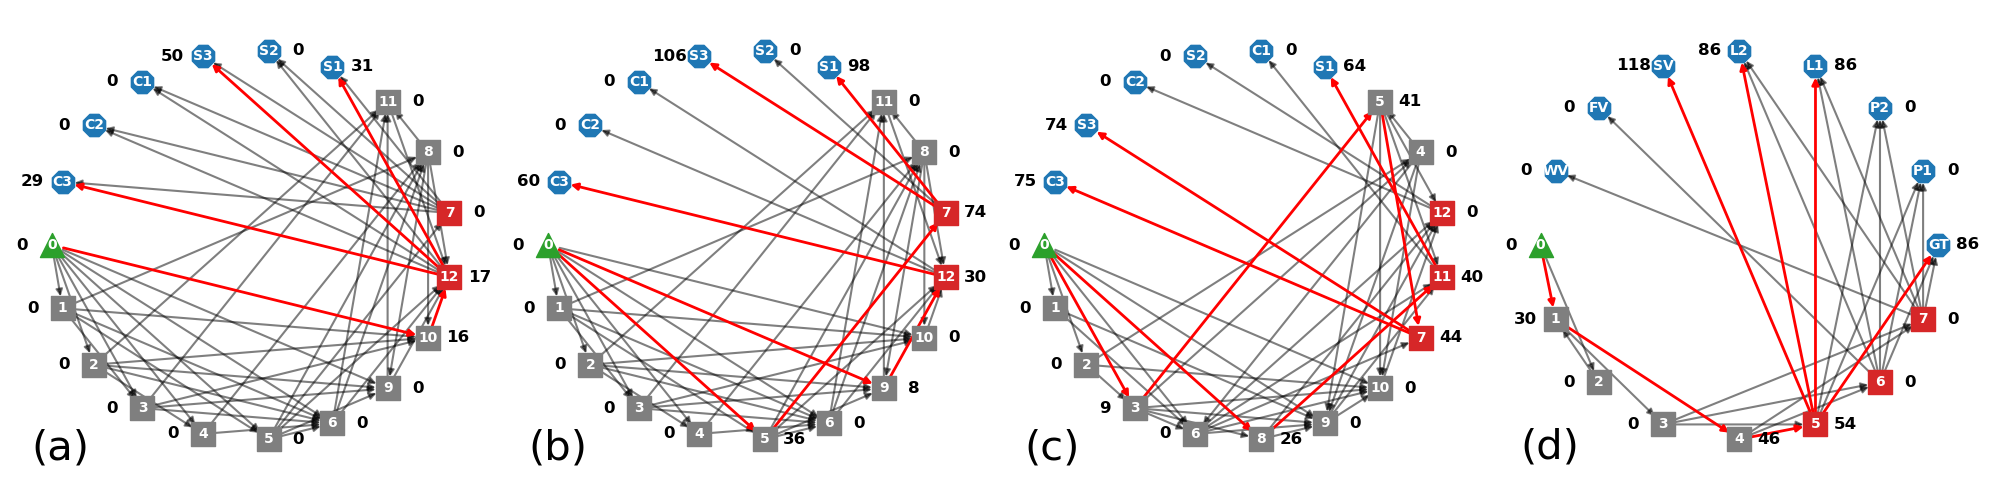

In [5]:
gs = gridspec.GridSpec(1, len(experiments))
fig = plt.figure(figsize=(20,5))
gs.tight_layout(fig)
mp = {1:'(a)', 2:'(b)', 3:'(c)', 4:'(d)'}
for k, v in cl.items():
    if 'weight' in set(chain.from_iterable(d.keys() for *_, d in v.DAG.edges(data=True))):
        for _, _, data in v.DAG.edges(data=True):
            data["time"] = data.pop("weight")
    v.init = [0]
            
    edge_labels = dict()
    for i, j, t in v.DAG.edges(data=True):
        edge_labels[(i, j)] = t['time']
    
    nodes_set = set(v.DAG.nodes())
    _, targets = get_points(v.DAG)
    mid_node_set = nodes_set - set(v.init) - set(v.ends) - set(targets)
    
    ff, hh = f[k], h[k]
    red_edges = [(i,j) for i,j in ff.keys() if ff[i,j] > 0 and j != 'AUX']
    black_edges = list(set(v.DAG.edges()) - set(red_edges))
    red_nodes = {i for edge in red_edges for i in edge}
    for node in v.DAG.nodes():
        hh[node] = hh[node] if node in red_nodes else 0
    kk = experiments.index(k)
    pos_higher = {}   
    pos = nx.shell_layout(v.DAG)
    for n, m in pos.items():
        if m[0] > 0:
            pos_higher[n] = (m[0] + 0.15, m[1])
        else:
            pos_higher[n] = (m[0] - 0.15, m[1])
    
    ax = fig.add_subplot(gs[0, kk])
    ax.text(-1.1,-1.1,mp[kk+1], fontsize='30')
    nx.draw_networkx_nodes(v.DAG, pos, ax=ax, nodelist=v.init, node_shape='^', 
                           node_color='tab:green')
    nx.draw_networkx_nodes(v.DAG, pos, ax=ax, nodelist=v.ends, node_shape='s', 
                           node_color='tab:red')
    nx.draw_networkx_nodes(v.DAG, pos, ax=ax, nodelist=list(mid_node_set), 
                           node_shape='s', node_color='tab:gray')
    nx.draw_networkx_nodes(v.DAG, pos, ax=ax, nodelist=targets, 
                           node_shape='8', node_color='tab:blue')
    nx.draw_networkx_labels(v.DAG, pos, ax=ax, font_size=10, font_color="white", font_weight='bold')
    nx.draw_networkx_labels(v.DAG, pos_higher, ax=ax, labels=hh, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(v.DAG, pos, ax=ax, edgelist=black_edges, edge_color= "black", width=1.5, alpha=0.5)
    nx.draw_networkx_edges(v.DAG, pos, ax=ax, edgelist=red_edges, edge_color= "red", width=2)
    fig.tight_layout()
    plt.axis("off")
plt.savefig(f'./img/topo-worst.pdf', format='pdf', dpi=1200, bbox_inches='tight')     
plt.show()

## **TTF and MTTF: Numerical Study**

In [6]:
typ = 1
path = os.path.join(OUT_PATH, 'random', f'type{typ}')
T = list(range(200, 1001, 100))
K = list(range(1, 7, 1))
sd_v = 0.1
sd_w = np.sqrt(0.001)
sd_s = 0.1
lb_a, ub_a = -3*sd_w , 3*sd_w
lb_b, ub_b = -3*sd_v , 3*sd_v
physical_states = 3
no_controllers = 3
no_sensors = 3
sim_inits = [0,0,0]
lamb = _read_scalar('lambda', 'random')
kappa = np.sqrt(2) * _read_scalar('kappa', 'random')
gamma = _read_vector('gamma', 'random')

In [7]:
a, b = dict(), dict()
for t in T:
    for k in K:
        _dir = os.path.join(path, f'T{t}-K{k}')
        a[t,k] = np.matrix(np.load(os.path.join(_dir, 'a.npy')))
        b[t,k] = np.matrix(np.load(os.path.join(_dir, 'b.npy')))

In [8]:
s = System(physical_states, no_controllers, no_sensors, sim_inits, 'random')
s.simulate(sd_v, sd_w, 1000)
f_sim = []
for t in tqdm(range(1, 1000+1), 
                desc="Generating z values for simulation ... "):
    z = z_tau(s.x, t, sd_s, lamb, kappa, gamma)
    f_sim.append(norm.pdf(z))  

Generating z values for simulation ... : 100%|██████████| 1000/1000 [00:00<00:00, 21085.81it/s]


In [9]:
f_opt = defaultdict(list)
x_os = dict()
for t in tqdm(T, desc="Generating z values for Optimization ... "):
    zero_mat_a = np.matrix(np.zeros((no_sensors, 1000-t)))
    zero_mat_b = np.matrix(np.zeros((physical_states, 1000-t)))
    for k in K:
        _a = np.c_[a[t,k], zero_mat_a]
        _b = np.c_[b[t,k], zero_mat_b]
        s.simulateAttack(_a, _b)
        x_os[t,k] = s.xa
        for tt in range(1, 1000+1):
            z = z_tau(s.xa, tt, sd_s, lamb, kappa, gamma)
            f_opt[t,k].append(norm.pdf(z))  

Generating z values for Optimization ... : 100%|██████████| 9/9 [00:04<00:00,  2.19it/s]


In [10]:
x_ax = np.arange(350,650)
color = cm.rainbow(np.linspace(0, 1, 2*len(T)))
linestyle = [(0, (3, 10, 1, 10, 1, 10)),
                (0, (3, 1, 1, 1)),
                'dashdot',
                (5, (10, 3)),
                (0, (5, 1)),
                'dashed',
                'dotted',
                (0, (3, 5, 1, 5)),
                (0, (3, 1, 1, 1, 1, 1))]

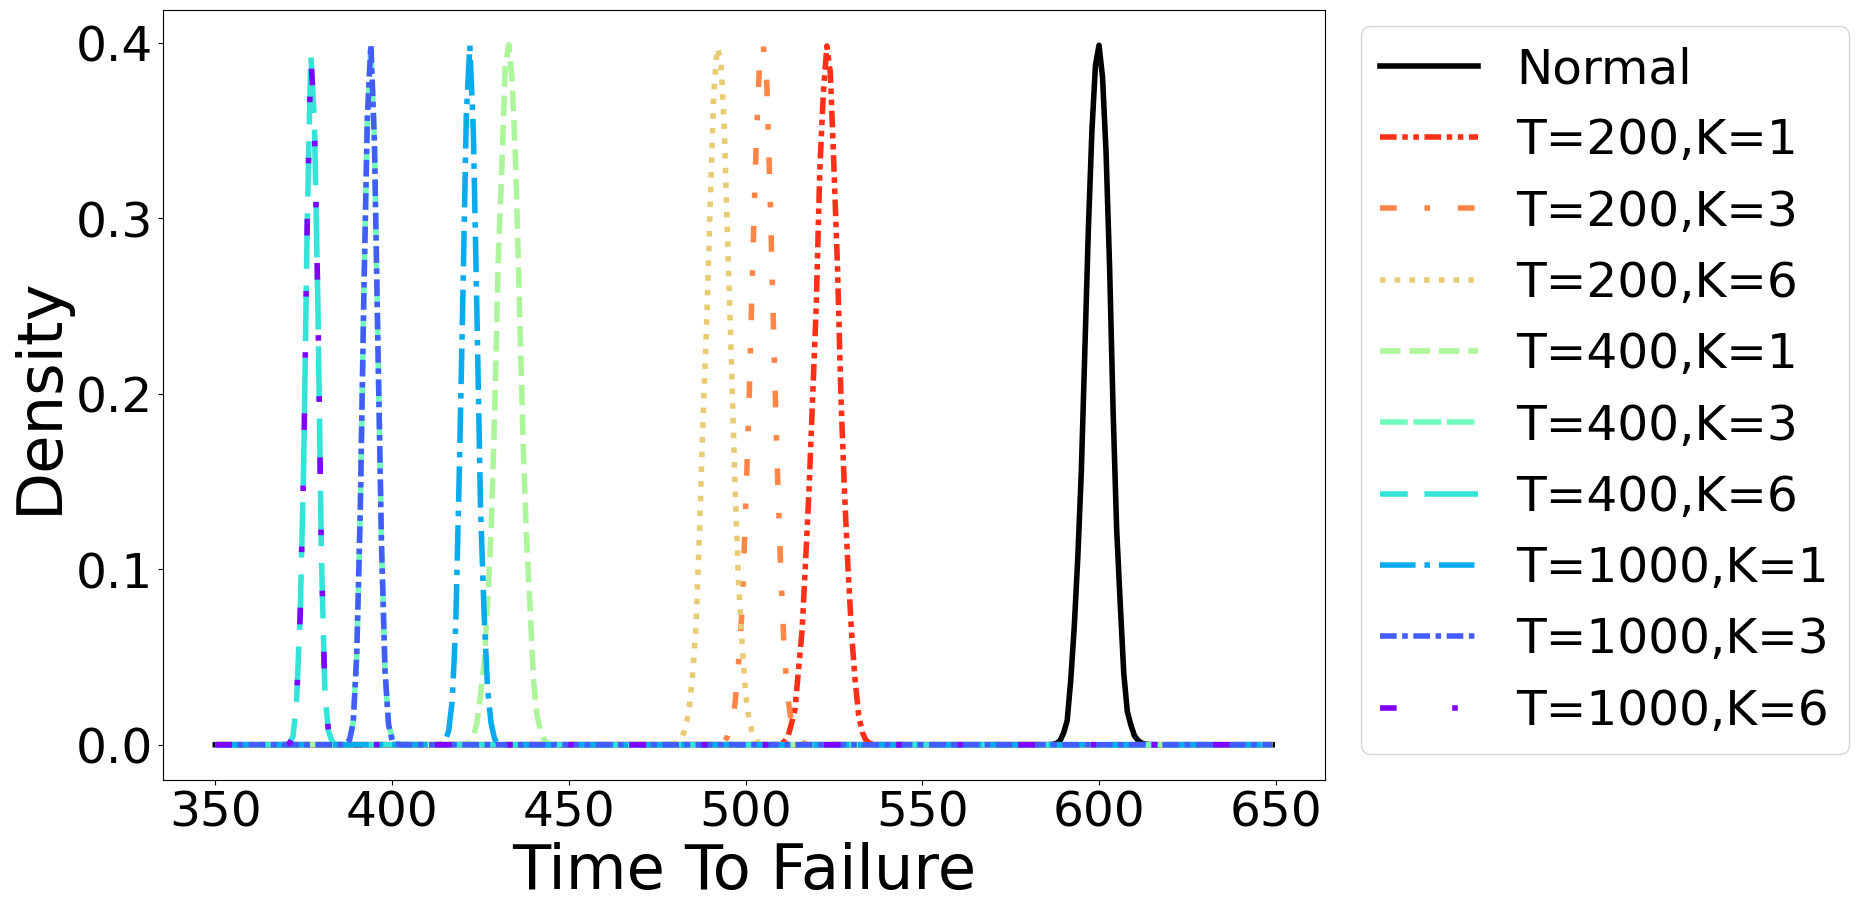

In [11]:
plt.figure(figsize=(15,10))
plt.plot(x_ax, f_sim[350:650], label='Normal', color='black', lw=4)
j = len(T)-1
for t in T:
    for k in K:
        if t in [200, 400, 1000] and k in [1,3,6]:
            plt.plot(x_ax, 
                        f_opt[t,k][350:650], 
                        color=color[2*j], 
                        linestyle=linestyle[j],
                        label=f'T={t},K={k}', 
                        lw=4)
            j -= 1
plt.ylabel("Density", fontsize=45)
plt.xlabel("Time To Failure", fontsize=45)
plt.tick_params(axis='both', which='major', labelsize=35)
plt.legend(prop={'size': 35}, bbox_to_anchor=(1.01, 1.01))
plt.savefig(f'./img/pdf_random.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

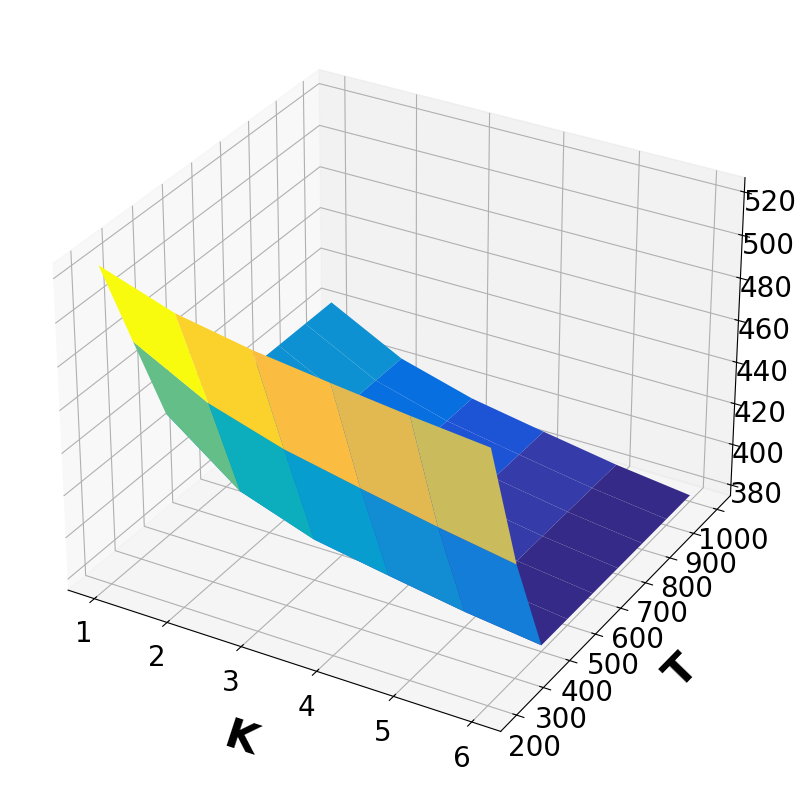

In [12]:
mtof = defaultdict()
for t in T:
    for k in K:
        _x = x_os[t,k]
        E = 0
        for tt in range(1, 1000+1):
            z = z_tau(_x, tt, sd_s, lamb, kappa, gamma)
            E += norm.cdf(z)
        mtof[t,k] = E

mtof_k, mtof_t = defaultdict(), defaultdict()

for k in K:
    mtof_k[k] = [vv for kk, vv in mtof.items() if kk[1] == k]
for t in T:
    mtof_t[t] = [vv for kk, vv in mtof.items() if kk[0] == t]

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
    [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
    [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
    0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
    [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
    0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
    [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
    0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
    [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
    0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
    [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
    0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
    [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
    0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
    0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
    [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
    0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
    [0.0589714286, 0.6837571429, 0.7253857143], 
    [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
    [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
    0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
    [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
    0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
    [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
    0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
    [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
    0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
    [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
    [0.7184095238, 0.7411333333, 0.3904761905], 
    [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
    0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
    [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
    [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
    0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
    [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
    0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
    [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
    [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
    [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
    0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
    [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
z = np.zeros((len(K), len(T)))
for t in T:
    for k in K:
        z[k-1, int(t/100)-2] = mtof[t,k]
x = np.arange(len(mtof_k.keys()))
y = np.arange(len(mtof_t.keys()))
X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, z.T, cmap=parula_map)

ax.xaxis.set_major_locator(mticker.MaxNLocator(len(K)))
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc[:-1]))
ax.set_xticklabels([0] + K, ha='center', fontsize=20)

ax.yaxis.set_major_locator(mticker.MaxNLocator(len(T)))
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc[:-1]))
ax.set_yticklabels([0] + T, ha='center', fontsize=20)
ax.tick_params(axis='z', which='major', labelsize=20)
ax.set_xlabel(r'$\mathbf{K}$', labelpad=20, rotation=-90, fontsize=30)
ax.set_ylabel(r'$\mathbf{T}$', labelpad=20, rotation=-90, fontsize=30)
ax.set_zlabel(r'$\mathbb{E}(\mathbf{T}_{f})$', labelpad=20, rotation=90, fontsize=30)
    
plt.show()

## **TTF and MTTF: Case Study**

In [13]:
path = os.path.join(OUT_PATH, 'case')
T = [100, 200, 400, 600, 1000]
K = list(range(1, 9, 1))
sd_v = 0.05
sd_w = 0.05
sd_s = 0.1
lb_a, ub_a = -3*sd_w , 3*sd_w
lb_b, ub_b = -3*sd_v , 3*sd_v
physical_states = 3
no_controllers = 3
no_sensors = 5
sim_inits = [0, 0, 0]
lamb = _read_scalar('lambda', 'case')
kappa = np.sqrt(2) * _read_scalar('kappa', 'case')
gamma = _read_vector('gamma', 'case')

In [14]:
a, b = dict(), dict()
for t in T:
    for k in K:
        _dir = os.path.join(path, f'T{t}-K{k}')
        _a = np.matrix(np.load(os.path.join(_dir, 'a.npy')))
        _b = np.matrix(np.load(os.path.join(_dir, 'b.npy')))
        _a[:,_a.shape[1]-1] = _a[:,_a.shape[1]-2]
        _b[:,_b.shape[1]-1] = _b[:,_b.shape[1]-2]
        a[t,k] = _a
        b[t,k] = _b

In [15]:
s = System(physical_states, no_controllers, no_sensors, sim_inits, 'case')
s.simulate(sd_v, sd_w, 1000)
f_sim = []
for t in tqdm(range(1, 1000+1), 
                desc="Generating z values for simulation ... "):
    _z = z_tau(s.x, t, sd_s, lamb, kappa, gamma)
    f_sim.append(norm.pdf(_z))  

f_opt = defaultdict(list)
x_os = dict()
for t in tqdm(T, desc="Generating z values for Optimization ... "):
    zero_mat_a = np.matrix(np.zeros((no_sensors, 1000-t)))
    zero_mat_b = np.matrix(np.zeros((physical_states, 1000-t)))
    for k in K:
        _a = np.c_[a[t,k], zero_mat_a]
        _b = np.c_[b[t,k], zero_mat_b]
        s.simulateAttack(_a, _b)
        x_os[t,k] = s.xa
        for tt in range(1, 1000+1):
            _z = z_tau(s.xa, tt, sd_s, lamb, kappa, gamma)
            f_opt[t,k].append(norm.pdf(_z))  

Generating z values for Optimization ... : 100%|██████████| 5/5 [00:03<00:00,  1.65it/s]


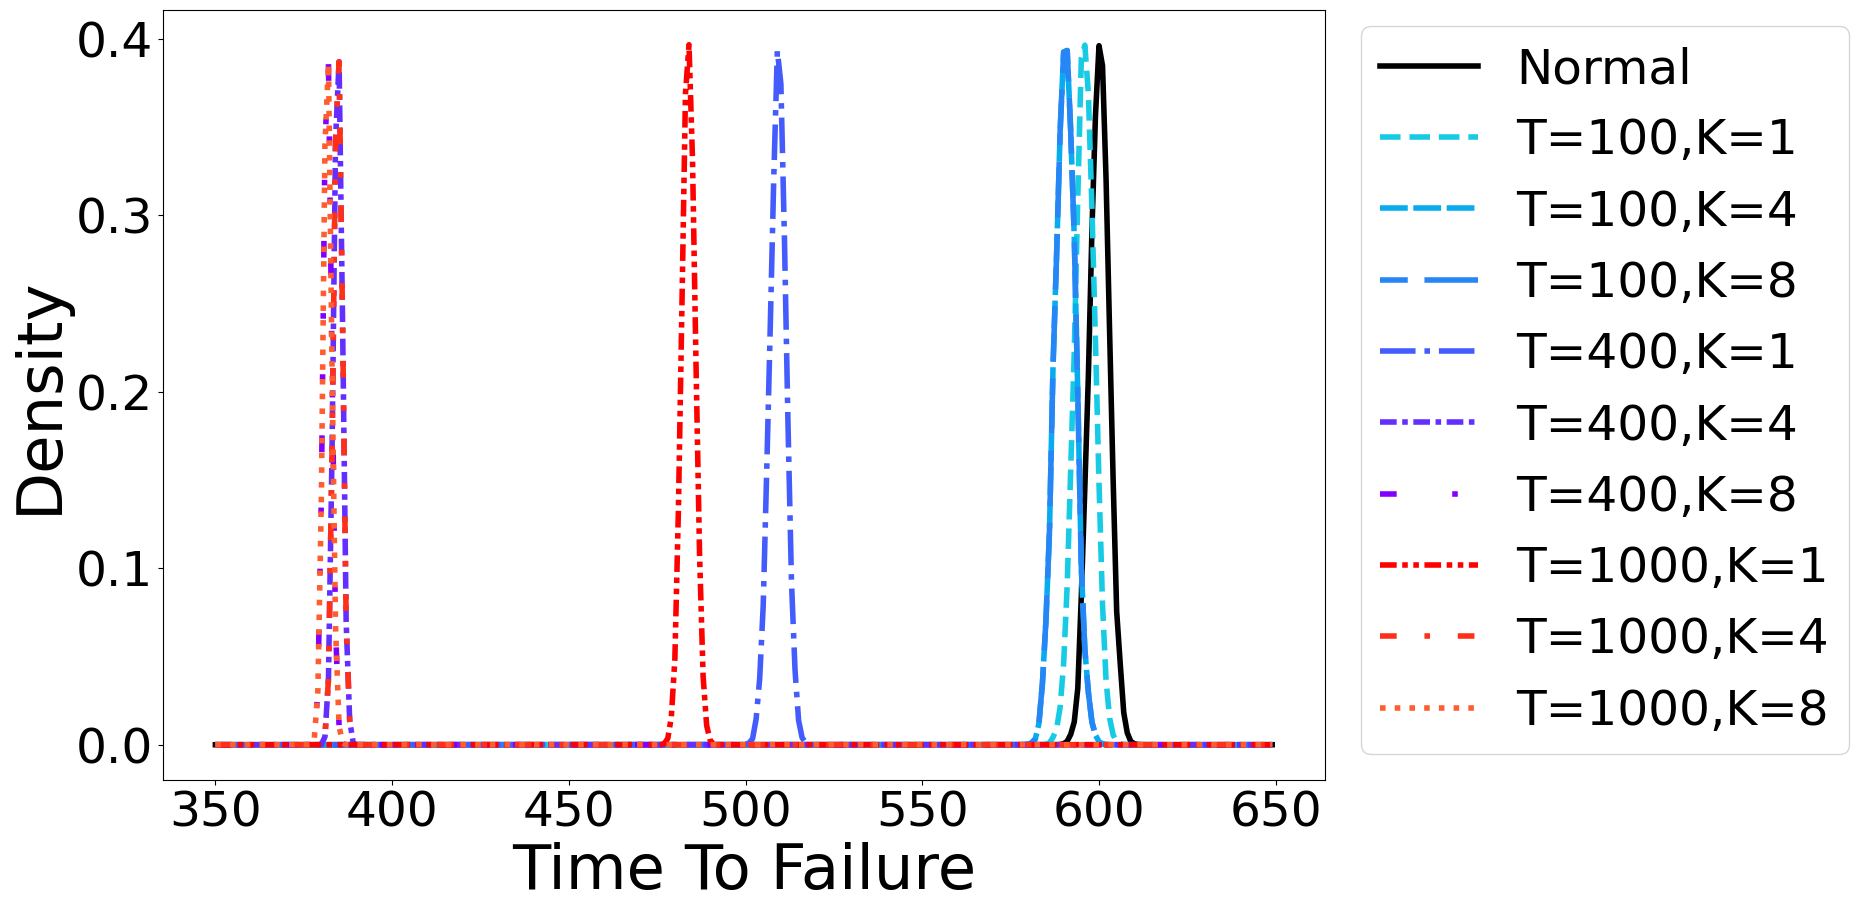

In [16]:
plt.figure(figsize=(15,10))
plt.plot(x_ax, f_sim[350:650], label='Normal', color='black', lw=4)
j = len(T)
for t in T:
    for k in K:
        if t in [100, 400, 1000] and k in [1,4,8]:
            plt.plot(x_ax, 
                    f_opt[t,k][350:650], 
                    color=color[j], 
                    linestyle=linestyle[j],
                    label=f'T={t},K={k}', 
                    lw=4)
            j -= 1
plt.ylabel("Density", fontsize=45)
plt.xlabel("Time To Failure", fontsize=45)
plt.tick_params(axis='both', which='major', labelsize=35)
plt.legend(prop={'size': 35}, bbox_to_anchor=(1.01, 1.01))
plt.savefig('./img/pdf_case.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

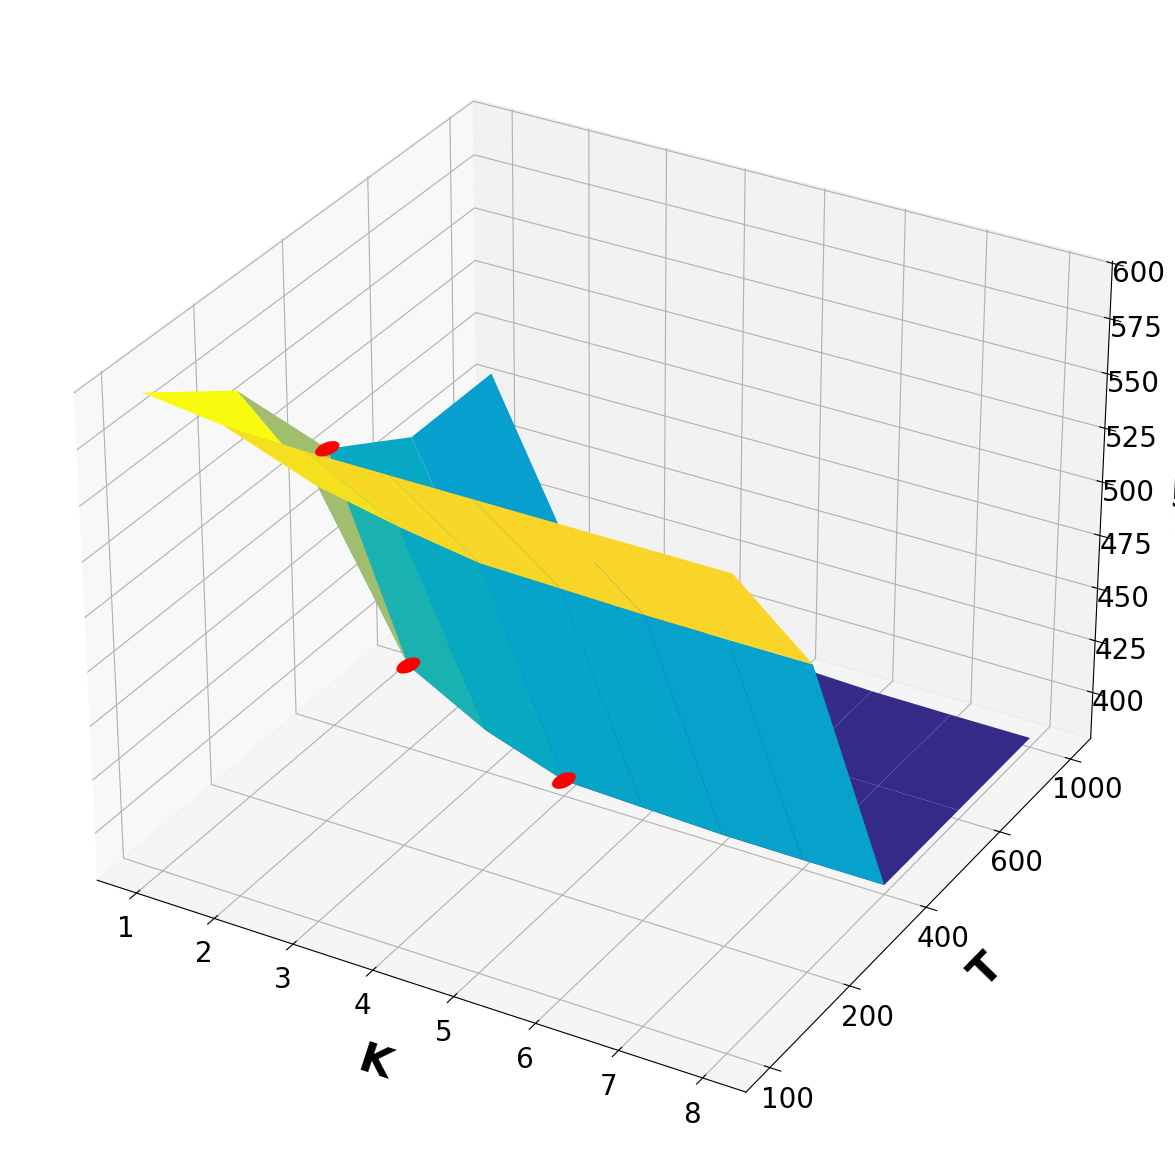

In [17]:
mtof = defaultdict()
for t in T:
    for k in K:
        _x = x_os[t,k]
        E = 0
        for tt in range(1, 1000+1):
            _z = z_tau(_x, tt, sd_s, lamb, kappa, gamma)
            E += norm.cdf(_z)
        mtof[t,k] = E

mtof_k, mtof_t = defaultdict(), defaultdict()

for k in K:
    mtof_k[k] = [vv for kk, vv in mtof.items() if kk[1] == k]
for t in T:
    mtof_t[t] = [vv for kk, vv in mtof.items() if kk[0] == t]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)
z = np.zeros((len(K), len(T)))
for t in T:
    for k in K:
        if t != 1000:
            z[k-1, int(t/200)] = mtof[t,k]
        else:
            z[k-1, int(t/200)-1] = mtof[t,k]
x = np.arange(len(mtof_k.keys()))
y = np.arange(len(mtof_t.keys()))
X, Y = np.meshgrid(x, y)
fig = plt.figure(figsize=(18, 15))
ax = plt.axes(projection='3d', zorder=False)
ax.plot_surface(X, Y, z.T, cmap=parula_map)
p1 = Circle((0, 2), 0.1, ec='r', fc='r', fill=True)
ax.add_patch(p1)
art3d.pathpatch_2d_to_3d(p1, z=mtof[400,1], zdir="z")
p2 = Circle((1, 2), 0.1, ec='r', fc='r', fill=True)
ax.add_patch(p2)
art3d.pathpatch_2d_to_3d(p2, z=mtof[400,2], zdir="z")
p3 = Circle((3, 2), 0.1, ec='r', fc='r', fill=True)
ax.add_patch(p3)
art3d.pathpatch_2d_to_3d(p3, z=mtof[400,4], zdir="z")

ax.xaxis.set_major_locator(mticker.MaxNLocator(len(K)))
ticks_loc = ax.get_xticks().tolist()
ax.xaxis.set_major_locator(mticker.FixedLocator(ticks_loc[:-1]))
ax.set_xticklabels([0] + K, ha='center', fontsize=20)

ax.yaxis.set_major_locator(mticker.MaxNLocator(len(T)))
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc[:-1]))
ax.set_yticklabels([0] + T, ha='center', fontsize=20)
ax.tick_params(axis='z', which='major', labelsize=20)
ax.set_xlabel(r'$\mathbf{K}$', labelpad=20, rotation=-90, fontsize=30)
ax.set_ylabel(r'$\mathbf{T}$', labelpad=20, rotation=-90, fontsize=30)
ax.set_zlabel(r'$\mathbb{E}(\mathbf{T}_{f})$', labelpad=20, rotation=90, fontsize=30)
    
plt.show()

## **Worst-case attack actions on sensors and controllers of the BWPP for $T=400$.**

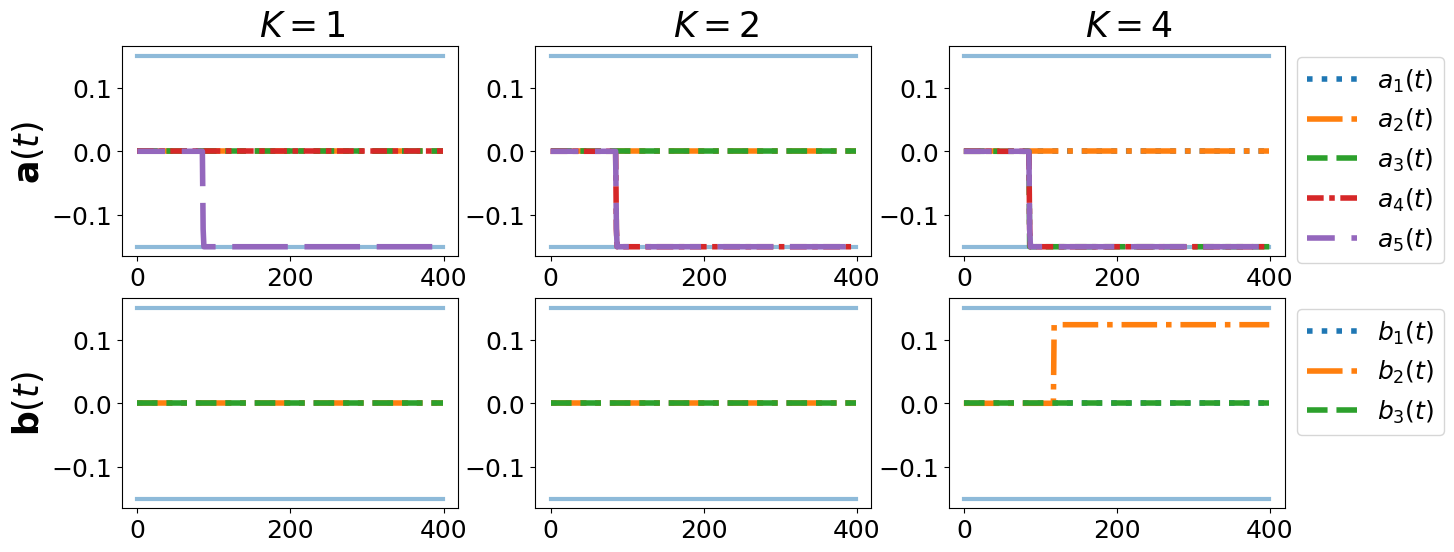

In [18]:
t = 400
x_ax = np.arange(t)
linestyle = ['dotted',
                'dashdot',
                'dashed',
                (0, (3, 1, 1, 1)),
                (5, (10, 3)),
                (0, (5, 1)),
                (0, (3, 10, 1, 10, 1, 10)),
                (0, (3, 5, 1, 5)),
                (0, (3, 1, 1, 1, 1, 1))]
markers = ['o', 'X', 'H', '+', '*', 'p', '^', '1', '+']
KK = [1,2,4]
fig, axs = plt.subplots(nrows=2, ncols=len(KK), figsize=(15,6))
plt.subplots_adjust(wspace=0.23)
for ax, col in zip(axs[0,:], [r'$K = {}$'.format(col) for col in KK]):
    ax.annotate(col, xy=(0.5, 1), xytext=(40, ax.yaxis.labelpad + 190),
                xycoords=ax.xaxis.label, textcoords='offset points',
                fontsize=25, ha='right', va='center')
for k in KK:
    _a, _b = a[t,k], b[t,k]
    
    axs[0,KK.index(k)].plot(x_ax, [lb_a]*t, color='tab:blue', 
                            linestyle='-', linewidth=3, alpha=0.5)
    axs[0,KK.index(k)].plot(x_ax, [ub_a]*t, color='tab:blue', 
                            linestyle='-', linewidth=3, alpha=0.5)
    j = 0
    for i in range(_a.shape[0]):
        axs[0,KK.index(k)].plot(x_ax, np.squeeze(np.asarray(_a[i,:])), 
                                label=r'$a_{}(t)$'.format(i+1), 
                                linestyle=linestyle[j],
                                linewidth=4)
        j += 1
    axs[0,KK.index(k)].tick_params(axis='both', which='major', labelsize=18)
    
    axs[1,KK.index(k)].plot(x_ax, [lb_b]*t, color='tab:blue', 
                            linestyle='-', linewidth=3, alpha=0.5)
    axs[1,KK.index(k)].plot(x_ax, [ub_b]*t, color='tab:blue', 
                            linestyle='-', linewidth=3, alpha=0.5)
    j = 0
    for i in range(_b.shape[0]):
        axs[1,KK.index(k)].plot(x_ax, np.squeeze(np.asarray(_b[i,:])), 
                                label=r'$b_{}(t)$'.format(i+1), 
                                linestyle=linestyle[j],
                                linewidth=4)
        j += 1
    axs[1,KK.index(k)].tick_params(axis='both', which='major', labelsize=18)

axs[1,0].set_ylabel(r"$\mathbf{b}(t)$", fontsize=25)
axs[0,0].set_ylabel(r"$\mathbf{a}(t)$", fontsize=25)
axs[0,2].legend(prop={'size': 18},bbox_to_anchor=(1.001, 1.01))
axs[1,2].legend(prop={'size': 18},bbox_to_anchor=(1.001, 1.01))
    
plt.savefig('./img/case-a-b.pdf', format='pdf', 
            dpi=1200, bbox_inches='tight')
plt.show()

## **Sensitivity Analysis**

In [19]:
def set_detection_params(d, sd_v, sd_w):
    detect_power = {
        'loose': 5,
        'medium': 3,
        'strict': 1
    }[d]

    lb_a = - np.round(detect_power * sd_w, 2)
    ub_a = np.round(detect_power * sd_w, 2)

    lb_b = - np.round(detect_power * sd_v, 2)
    ub_b = np.round(detect_power * sd_v, 2)
    return lb_a, ub_a, lb_b, ub_b

In [20]:
typ = 1
path = os.path.join(OUT_PATH, 'sa', f'type{typ}')
detection = ['loose', 'medium', 'strict']
lables = {'loose': 'low', 'medium': 'moderate', 'strict': 'hight'}
T = 400
K = 3
sd_v = 0.1
sd_w = np.sqrt(0.001)
sd_s = 0.1
lb_a, ub_a = dict(), dict()
lb_b, ub_b = dict(), dict()
a, b = dict(), dict()
physical_states = 3
no_controllers = 3
no_sensors = 3
sim_inits = [0,0,0]
lamb = _read_scalar('lambda', 'random')
kappa = np.sqrt(2) * _read_scalar('kappa', 'random')
gamma = _read_vector('gamma', 'random')

In [21]:
for d in detection:
    _dir = os.path.join(path, f'detection_{d}')
    lb_a[d], ub_a[d], lb_b[d], ub_b[d] = set_detection_params(d, sd_v, sd_w)
    a[d] = np.matrix(np.load(os.path.join(_dir, 'a.npy')))
    b[d] = np.matrix(np.load(os.path.join(_dir, 'b.npy')))

In [22]:
s = System(physical_states, no_controllers, no_sensors, sim_inits, 'random')
s.simulate(sd_v, sd_w, 1000)
f_sim = []
for t in tqdm(range(1, 1000+1), 
                desc="Generating z values for simulation ... "):
    z = z_tau(s.x, t, sd_s, lamb, kappa, gamma)
    f_sim.append(norm.pdf(z))  

f_opt = defaultdict(list)
x_os = dict()
for d in tqdm(detection, desc="Generating z values for Optimization ... "):
    zero_mat_a = np.matrix(np.zeros((no_sensors, 1000 - T)))
    zero_mat_b = np.matrix(np.zeros((physical_states, 1000 - T)))
    _a = np.c_[a[d], zero_mat_a]
    _b = np.c_[b[d], zero_mat_b]
    s.simulateAttack(_a, _b)
    x_os[d] = s.xa
    for tt in range(1, 1000+1):
        z = z_tau(s.xa, tt, sd_s, lamb, kappa, gamma)
        f_opt[d].append(norm.pdf(z))  

Generating z values for Optimization ... : 100%|██████████| 3/3 [00:00<00:00, 15.09it/s]


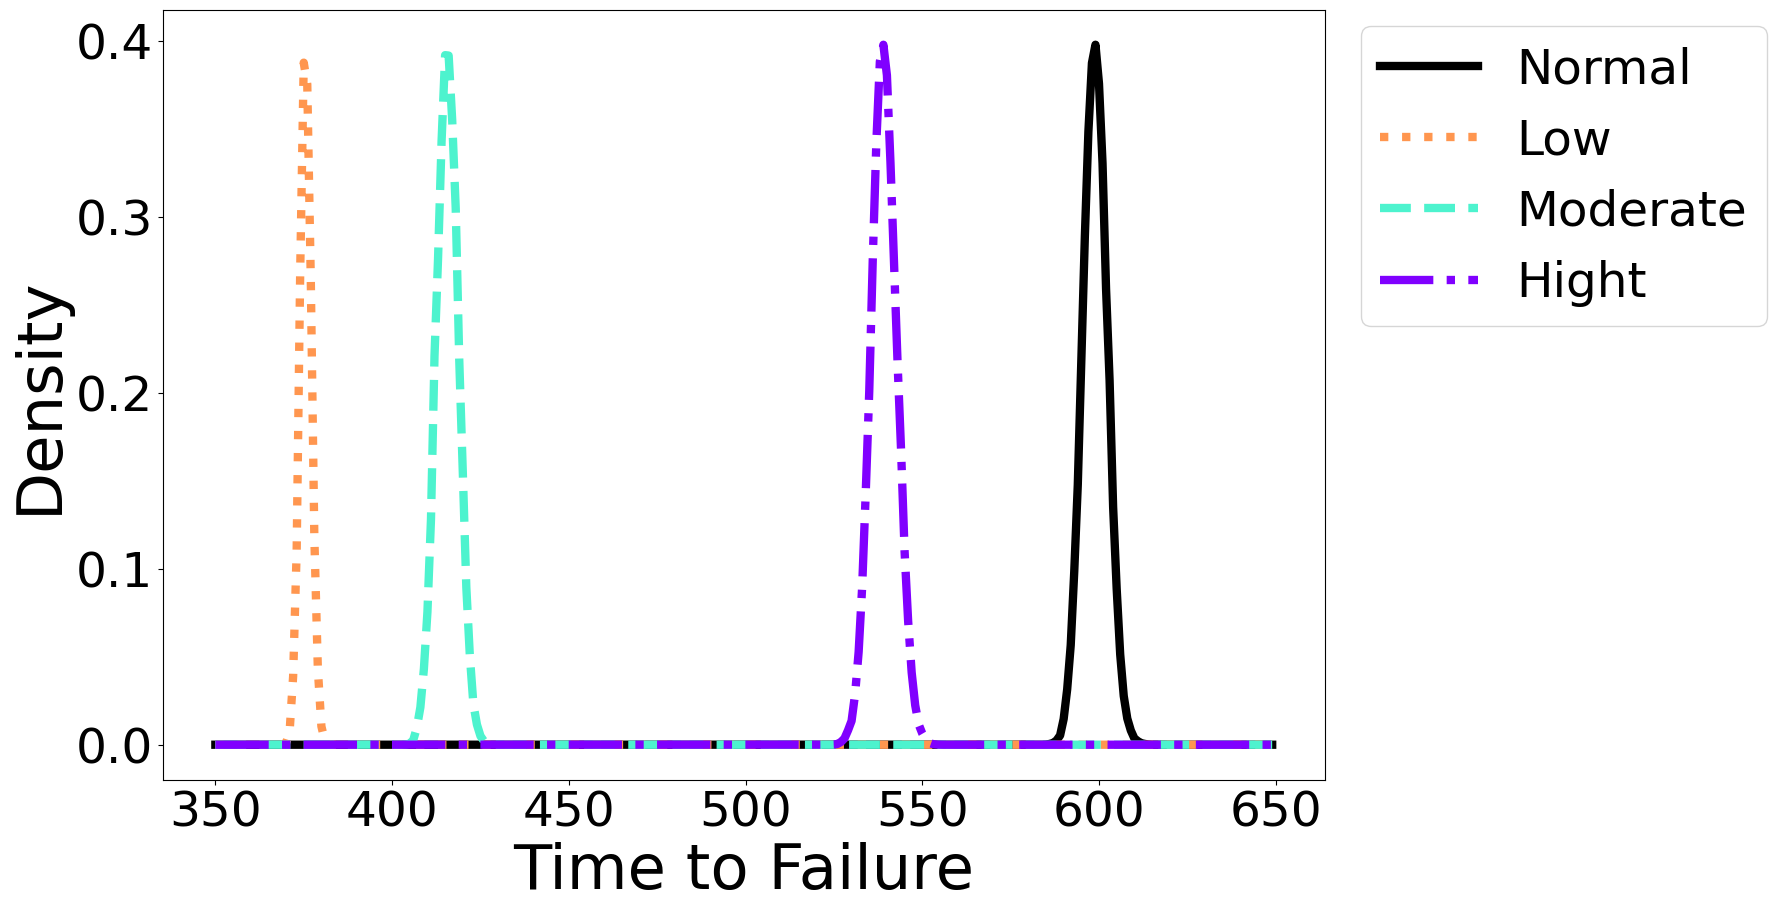

In [23]:
x_ax = np.arange(350,650)
color = cm.rainbow(np.linspace(0, 1, 2*len(detection)))
linestyle = ['dashdot',
            'dashed',
            'dotted',]

plt.figure(figsize=(15,10))
plt.plot(x_ax, f_sim[350:650], label='Normal', color='black', lw=6)
j = len(detection)-1
for d in detection:
    plt.plot(x_ax, 
            f_opt[d][350:650], 
            color=color[2*j], 
            linestyle=linestyle[j],
            label=f'{lables[d].capitalize()}', 
            lw=6)
    j -= 1
plt.ylabel("Density", fontsize=45)
plt.xlabel("Time to Failure", fontsize=45)
plt.tick_params(axis='both', which='major', labelsize=35)
plt.legend(prop={'size': 35}, bbox_to_anchor=(1.01, 1.01))
plt.savefig(f'./img/sa_pdf.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

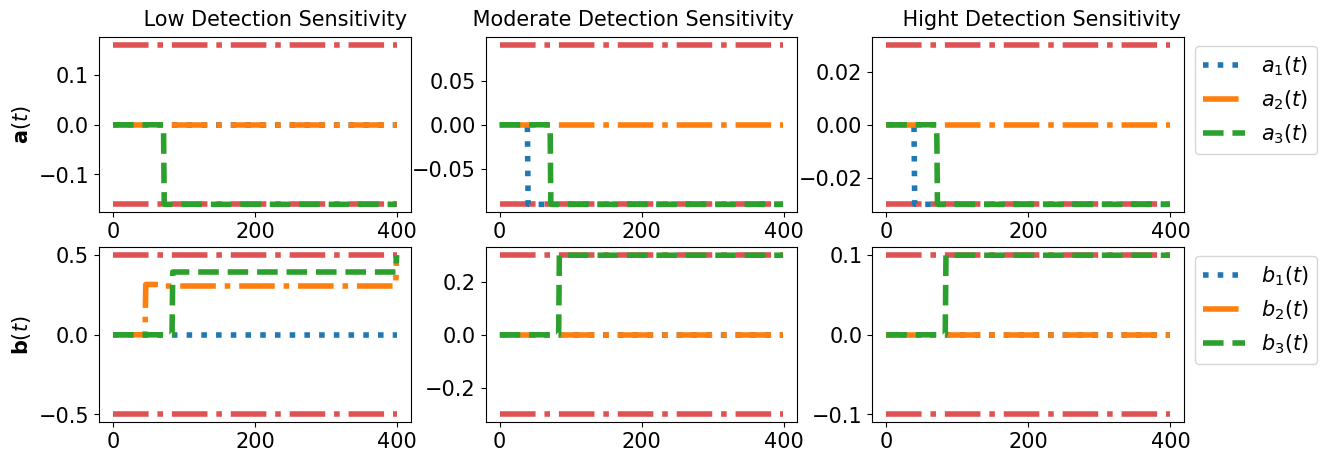

In [24]:
linestyle = ['dotted',
            'dashdot',
            'dashed',
            (0, (3, 1, 1, 1)),
            (5, (10, 3)),
            (0, (5, 1)),
            (0, (3, 10, 1, 10, 1, 10)),
            (0, (3, 5, 1, 5)),
            (0, (3, 1, 1, 1, 1, 1))]

fig, axs = plt.subplots(nrows=2, ncols=len(detection), figsize=(14,5))
plt.subplots_adjust(wspace=0.24)
for ax, col in zip(axs[0,:], 
                    [' {} Detection Sensitivity'.format(lables[col].capitalize()) 
                    for col in detection]):
    ax.annotate(col, xy=(0.5, 1), xytext=(110,ax.yaxis.labelpad + 160),
                xycoords=ax.xaxis.label, textcoords='offset points',
                fontsize=15, ha='right', va='center')
x_ax = np.arange(T)
for d in detection:
    _a, _b = a[d], b[d]
    _idx = detection.index(d)
    axs[0,_idx].plot(x_ax, [lb_a[d]]*T, color='tab:red', 
                        linestyle='-.', linewidth=4, alpha=0.8)
    axs[0,_idx].plot(x_ax, [ub_a[d]]*T, color='tab:red', 
                        linestyle='-.', linewidth=4, alpha=0.8)
    j = 0
    for i in range(_a.shape[0]):
        axs[0,_idx].plot(x_ax, np.squeeze(np.asarray(_a[i,:])), 
                            linestyle=linestyle[j],
                            label=r'$a_{}(t)$'.format(i+1), linewidth=4)
        j += 1
    axs[0,_idx].tick_params(axis='both', which='major', labelsize=15)
    
    axs[1,_idx].plot(x_ax, [lb_b[d]]*T, color='tab:red', 
                        linestyle='-.', linewidth=4, alpha=0.8)
    axs[1,_idx].plot(x_ax, [ub_b[d]]*T, color='tab:red', 
                        linestyle='-.', linewidth=4, alpha=0.8)
    j = 0
    for i in range(_b.shape[0]):
        axs[1,_idx].plot(x_ax, np.squeeze(np.asarray(_b[i,:])),
                            linestyle=linestyle[j],
                            label=r'$b_{}(t)$'.format(i+1), linewidth=4)
        j += 1
    axs[1,_idx].tick_params(axis='both', which='major', labelsize=15)
axs[0,2].legend(prop={'size': 15},bbox_to_anchor=(1.001, 1.01))
axs[1,2].legend(prop={'size': 15},bbox_to_anchor=(1.001, 1.01))
axs[0,0].set_ylabel(r"$\mathbf{a}(t)$", fontsize=15)
axs[1,0].set_ylabel(r"$\mathbf{b}(t)$", fontsize=15)
plt.savefig(f'./img/sa_actions.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## **Cyber-Physical Integration Impact**

In [25]:
cl = dict()
f = dict()
h = dict()
experiments = ['type1', 'type2', 'type3', 'case']
for experiment_name in experiments:
    if experiment_name.startswith('type'):
        t = 400
        k = 3
        ag_path = os.path.join(DATA_PATH,'random', f'cl-{experiment_name}.pkl')
        result_path = os.path.join(OUT_PATH, 'cyber', experiment_name, f'K{k}')
    else:
        t = 400
        k = 4
        ag_path = os.path.join(DATA_PATH, 'case', 'cl.pkl')
        result_path = os.path.join(OUT_PATH, 'cyber', 'case', f'K{k}')
    with open(ag_path, 'rb') as fl:
        cl[experiment_name] = pickle.load(fl)
    with open(os.path.join(result_path, 'f.pkl'), 'rb') as fl:
        f[experiment_name] = pickle.load(fl)
    with open(os.path.join(result_path, 'h.pkl'), 'rb') as fl:
        h[experiment_name] = pickle.load(fl)

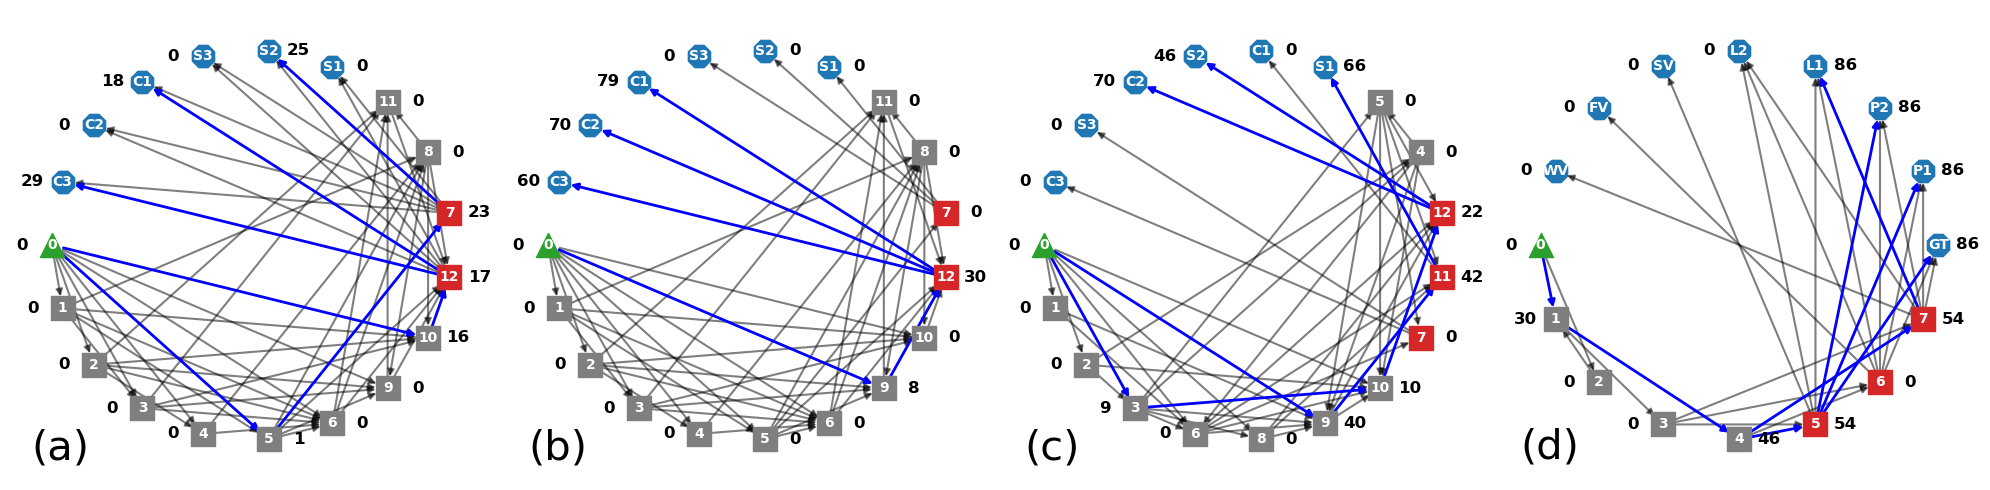

In [26]:
gs = gridspec.GridSpec(1, len(experiments))
fig = plt.figure(figsize=(20,5))
gs.tight_layout(fig)
mp = {1:'(a)', 2:'(b)', 3:'(c)', 4:'(d)'}
for k, v in cl.items():
    if 'weight' in set(chain.from_iterable(d.keys() for *_, d in v.DAG.edges(data=True))):
        for _, _, data in v.DAG.edges(data=True):
            data["time"] = data.pop("weight")
    v.init = [0]
            
    edge_labels = dict()
    for i, j, t in v.DAG.edges(data=True):
        edge_labels[(i, j)] = t['time']
    
    nodes_set = set(v.DAG.nodes())
    _, targets = get_points(v.DAG)
    mid_node_set = nodes_set - set(v.init) - set(v.ends) - set(targets)
    
    ff, hh = f[k], h[k]
    red_edges = [(i,j) for i,j in ff.keys() if ff[i,j] > 0 and j != 'AUX']
    black_edges = list(set(v.DAG.edges()) - set(red_edges))
    red_nodes = {i for edge in red_edges for i in edge}
    for node in v.DAG.nodes():
        hh[node] = hh[node] if node in red_nodes else 0
    kk = experiments.index(k)
    pos_higher = {}   
    pos = nx.shell_layout(v.DAG)
    for n, m in pos.items():
        if m[0] > 0:
            pos_higher[n] = (m[0] + 0.15, m[1])
        else:
            pos_higher[n] = (m[0] - 0.15, m[1])
    
    ax = fig.add_subplot(gs[0, kk])
    ax.text(-1.1,-1.1,mp[kk+1], fontsize='30')
    nx.draw_networkx_nodes(v.DAG, pos, ax=ax, nodelist=v.init, node_shape='^', 
                           node_color='tab:green')
    nx.draw_networkx_nodes(v.DAG, pos, ax=ax, nodelist=v.ends, node_shape='s', 
                           node_color='tab:red')
    nx.draw_networkx_nodes(v.DAG, pos, ax=ax, nodelist=list(mid_node_set), 
                           node_shape='s', node_color='tab:gray')
    nx.draw_networkx_nodes(v.DAG, pos, ax=ax, nodelist=targets, 
                           node_shape='8', node_color='tab:blue')
    nx.draw_networkx_labels(v.DAG, pos, ax=ax, font_size=10, font_color="white", font_weight='bold')
    nx.draw_networkx_labels(v.DAG, pos_higher, ax=ax, labels=hh, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(v.DAG, pos, ax=ax, edgelist=black_edges, edge_color= "black", width=1.5, alpha=0.5)
    nx.draw_networkx_edges(v.DAG, pos, ax=ax, edgelist=red_edges, edge_color= "blue", width=2)
    fig.tight_layout()
    plt.axis("off")
plt.savefig(f'./img/topo-cyber.pdf', format='pdf', dpi=1200, bbox_inches='tight')     
plt.show()

In [27]:
T = 400
study = ['worst', 'disjoint']
a, b = dict(), dict()
for s in study:
    for experiment_name in experiments:
        if experiment_name.startswith('type') and s == 'worst':
            path = os.path.join(OUT_PATH, 'random', experiment_name, f'T{T}-K3')
        elif experiment_name.startswith('case') and s == 'worst':
            path = os.path.join(OUT_PATH, experiment_name, f'T{T}-K4')
        elif experiment_name.startswith('type') and s == 'disjoint':
            path = os.path.join(OUT_PATH, 'disjoint', experiment_name, f'T{T}-K3')
        else:
            path = os.path.join(OUT_PATH, 'disjoint', experiment_name, f'T{T}-K4')
        a[s,experiment_name] = np.matrix(np.load(os.path.join(path, 'a.npy')))
        b[s,experiment_name] = np.matrix(np.load(os.path.join(path, 'b.npy')))

In [28]:
f_sim = defaultdict(list)
f_opt = defaultdict(list)
for experiment_name in experiments:
    if experiment_name.startswith('type'):
        sd_v = 0.1
        sd_w = np.sqrt(0.001)
        sd_s = 0.1
        physical_states = 3
        no_controllers = 3
        no_sensors = 3
        sim_inits = [0,0,0]
        lamb = _read_scalar('lambda', 'random')
        kappa = np.sqrt(2) * _read_scalar('kappa', 'random')
        gamma = _read_vector('gamma', 'random')
        expr = 'random'
    else:
        sd_v = 0.05
        sd_w = 0.05
        sd_s = 0.1
        physical_states = 3
        no_controllers = 3
        no_sensors = 5
        sim_inits = [0, 0, 0]
        lamb = _read_scalar('lambda', experiment_name)
        kappa = np.sqrt(2) * _read_scalar('kappa', experiment_name)
        gamma = _read_vector('gamma', experiment_name)
        expr = experiment_name
        
    lb_a, ub_a = -3*sd_w , 3*sd_w
    lb_b, ub_b = -3*sd_v , 3*sd_v
    
    for st in study:
        s = System(physical_states, no_controllers, no_sensors, 
                    sim_inits, expr)
        s.simulate(sd_v, sd_w, 1000)
        for t in tqdm(range(1, 1000+1), 
                        desc=f"Generating z values for simulation for {st} {experiment_name} ... "):
            _z = z_tau(s.x, t, sd_s, lamb, kappa, gamma)
            f_sim[st,experiment_name].append(norm.pdf(_z))
        zero_mat_a = np.matrix(np.zeros((no_sensors, 1000-T)))
        zero_mat_b = np.matrix(np.zeros((physical_states, 1000-T)))
        _a = np.c_[a[st,experiment_name], zero_mat_a]
        _b = np.c_[b[st,experiment_name], zero_mat_b]
        
        s.simulateAttack(_a, _b)
        for tt in tqdm(range(1, 1000+1), 
                        desc=f"Generating z values for Optimization for {st} {experiment_name} ... "):
            _z = z_tau(s.xa, tt, sd_s, lamb, kappa, gamma)
            f_opt[st,experiment_name].append(norm.pdf(_z))  

Generating z values for simulation for worst type1 ... : 100%|██████████| 1000/1000 [00:00<00:00, 15500.36it/s]
Generating z values for Optimization for worst type1 ... : 100%|██████████| 1000/1000 [00:00<00:00, 21154.72it/s]
Generating z values for simulation for disjoint type1 ... : 100%|██████████| 1000/1000 [00:00<00:00, 20446.16it/s]
Generating z values for Optimization for disjoint type1 ... : 100%|██████████| 1000/1000 [00:00<00:00, 26516.86it/s]
Generating z values for simulation for worst type2 ... : 100%|██████████| 1000/1000 [00:00<00:00, 21847.84it/s]
Generating z values for Optimization for worst type2 ... : 100%|██████████| 1000/1000 [00:00<00:00, 20218.58it/s]
Generating z values for simulation for disjoint type2 ... : 100%|██████████| 1000/1000 [00:00<00:00, 21150.99it/s]
Generating z values for Optimization for disjoint type2 ... : 100%|██████████| 1000/1000 [00:00<00:00, 25775.10it/s]
Generating z values for simulation for worst type3 ... : 100%|██████████| 1000/1000 

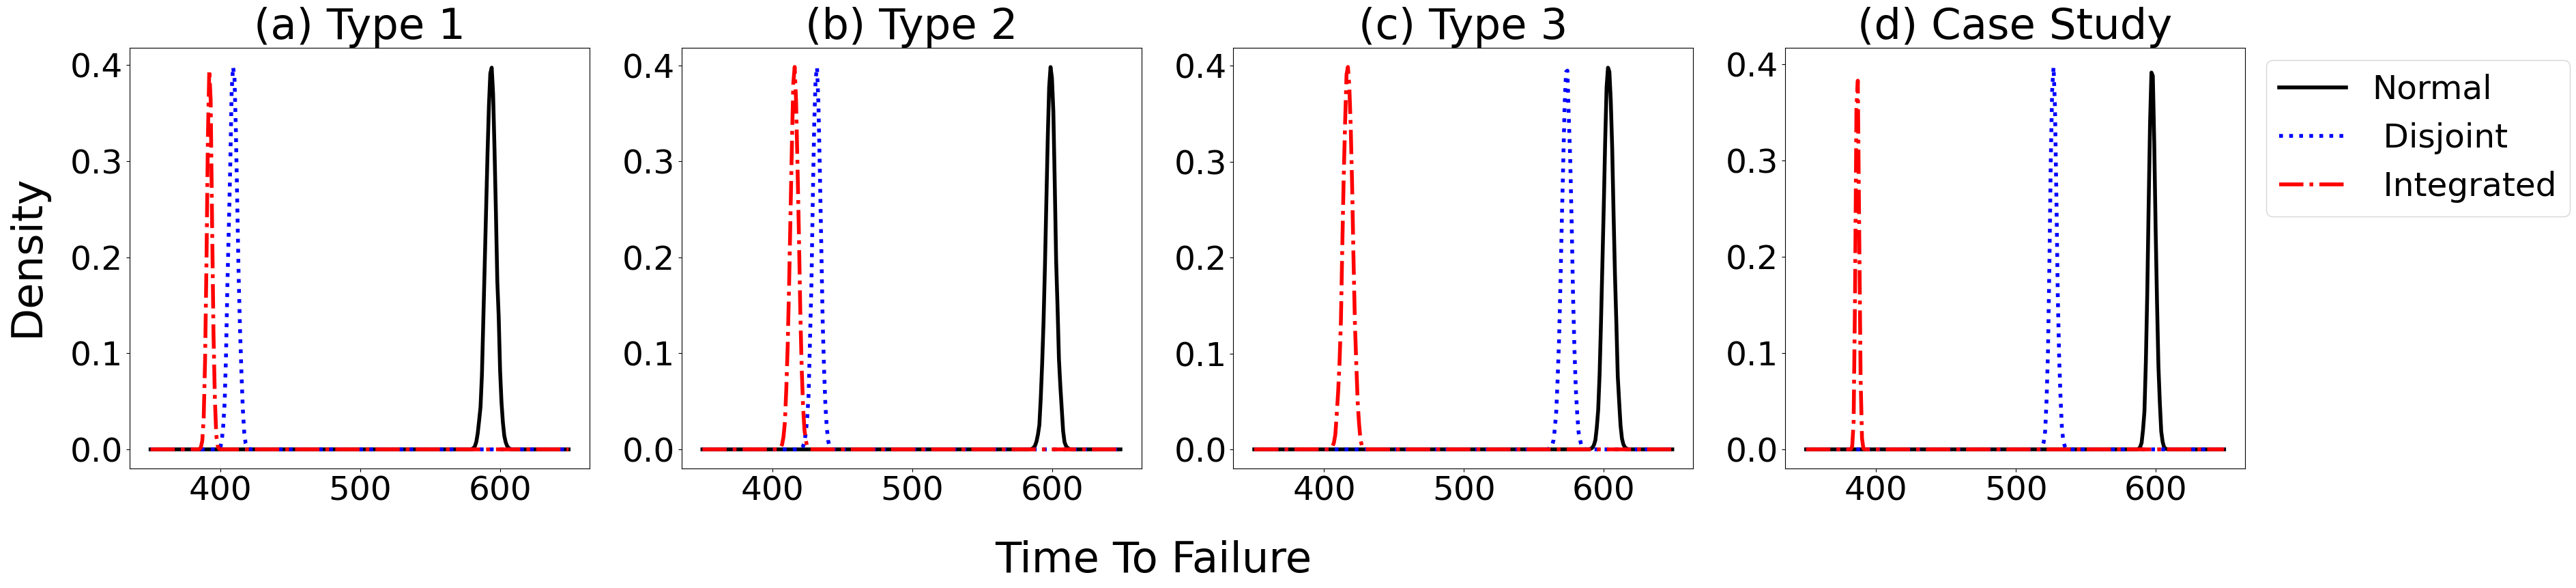

In [29]:
x_ax = np.arange(350,650)
mp = {0:'(a)', 1:'(b)', 2:'(c)'}

fig, ax = plt.subplots(1, len(experiments), figsize=(40,8))
for i in range(len(experiments)-1):
    ax[i].plot(x_ax, f_sim['disjoint',f'type{i+1}'][350:650], 
                label='Normal', color='black', lw=4)
    ax[i].plot(x_ax, 
                f_opt['disjoint',f'type{i+1}'][350:650], 
                color='blue', 
                linestyle='dotted',
                label=' Disjoint', 
                lw=4)
    ax[i].plot(x_ax, 
                f_opt['worst',f'type{i+1}'][350:650], 
                color='red', 
                linestyle='dashdot',
                label=' Integrated', 
                lw=4)
    ax[i].set_title(f'{mp[i]} Type {i+1}', fontsize=45)
    ax[i].tick_params(axis='both', which='major', labelsize=35)
ax[-1].plot(x_ax, f_sim['disjoint','case'][350:650], 
            label='Normal', color='black', lw=4)
ax[-1].plot(x_ax, 
            f_opt['disjoint','case'][350:650], 
            color='blue', 
            linestyle='dotted',
            label=' Disjoint', 
            lw=4)
ax[-1].plot(x_ax, 
            f_opt['worst','case'][350:650], 
            color='red', 
            linestyle='dashdot',
            label=' Integrated', 
            lw=4)
ax[-1].set_title('(d) Case Study', fontsize=45)
ax[-1].tick_params(axis='both', which='major', labelsize=35)
fig.text(0.5, -0.08, "Time To Failure", ha='center', fontsize=45)
fig.text(0.08, 0.5, "Density", va='center', rotation='vertical', fontsize=45)
plt.legend(prop={'size': 35}, bbox_to_anchor=(1.01, 1.01))
plt.savefig('./img/pdf_integrate.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

## **Comparative Analysis**

In [38]:
T = [200, 400, 600, 1000]
K = [1, 3, 8]
sd_v = 0.05
sd_w = 0.05
sd_s = 0.1
lb_a, ub_a = -3*sd_w , 3*sd_w
lb_b, ub_b = -3*sd_v , 3*sd_v
physical_states = 3
no_controllers = 3
no_sensors = 5
sim_inits = [0, 0, 0]
lamb = _read_scalar('lambda', 'case')
kappa = np.sqrt(2) * _read_scalar('kappa', 'case')
gamma = _read_vector('gamma', 'case')
a, b = defaultdict(), defaultdict()
for t in T:
    _dir = os.path.join(OUT_PATH, 'biehler', f'T{t}')
    a['b',t] = np.matrix(np.load(os.path.join(_dir, 'a.npy')))
    b['b',t] = np.matrix(np.load(os.path.join(_dir, 'b.npy')))
for t in T:
    _dir = os.path.join(OUT_PATH, 'huang', f'T{t}')
    a['h',t] = np.matrix(np.load(os.path.join(_dir, 'a.npy')))
    b['h',t] = np.matrix(np.load(os.path.join(_dir, 'b.npy')))
for t in T:
    _dir = os.path.join(OUT_PATH, 'case', f'T{t}-K1')
    a['k1',t] = np.matrix(np.load(os.path.join(_dir, 'a.npy')))
    b['k1',t] = np.matrix(np.load(os.path.join(_dir, 'b.npy')))
for t in T:
    _dir = os.path.join(OUT_PATH, 'case', f'T{t}-K3')
    a['k3',t] = np.matrix(np.load(os.path.join(_dir, 'a.npy')))
    b['k3',t] = np.matrix(np.load(os.path.join(_dir, 'b.npy')))
for t in T:
    _dir = os.path.join(OUT_PATH, 'case', f'T{t}-K8')
    a['k8',t] = np.matrix(np.load(os.path.join(_dir, 'a.npy')))
    b['k8',t] = np.matrix(np.load(os.path.join(_dir, 'b.npy')))

In [31]:
s = System(physical_states, no_controllers, no_sensors, sim_inits, 'case')
s.simulate(sd_v, sd_w, 1000)
f_sim = []
for t in tqdm(range(1, 1000+1), 
                desc="Generating z values for simulation ... "):
    _z = z_tau(s.x, t, sd_s, lamb, kappa, gamma)
    f_sim.append(norm.pdf(_z))  

f_opt = defaultdict(list)
x_os = dict()
for k in K:
    for t in T:
        zero_mat_a = np.matrix(np.zeros((no_sensors, 1000-t)))
        zero_mat_b = np.matrix(np.zeros((physical_states, 1000-t)))
        _a = np.c_[a[f'k{k}',t], zero_mat_a]
        _b = np.c_[b[f'k{k}',t], zero_mat_b]
        s.simulateAttack(_a, _b)
        x_os[f'k{k}',t] = s.xa
        for tt in tqdm(range(1, 1000+1), 
                        desc=f"Generating z values for worst-case attack T{t} K{k} ... "):
            _z = z_tau(s.xa, tt, sd_s, lamb, kappa, gamma)
            f_opt[f'k{k}',t].append(norm.pdf(_z))  
        
f_opth = defaultdict(list)
x_osh = dict()
for t in T:
    zero_mat_a = np.matrix(np.zeros((no_sensors, 1000-t)))
    zero_mat_b = np.matrix(np.zeros((physical_states, 1000-t)))
    _a = np.c_[a['h',t], zero_mat_a]
    _b = np.c_[b['h',t], zero_mat_b]
    s.simulateAttack(_a, _b)
    x_osh[t] = s.xa
    for tt in tqdm(range(1, 1000+1), 
                    desc=f"Generating z values for Huang et al. scenario T{t} ... "):
        _z = z_tau(s.xa, tt, sd_s, lamb, kappa, gamma)
        f_opth[t].append(norm.pdf(_z))  

f_optb = defaultdict(list)
x_osb = dict()
for t in T:
    zero_mat_a = np.matrix(np.zeros((no_sensors, 1000-t)))
    zero_mat_b = np.matrix(np.zeros((physical_states, 1000-t)))
    _a = np.c_[a['b',t], zero_mat_a]
    _b = np.c_[b['b',t], zero_mat_b]
    s.simulateAttack(_a, _b)
    x_osb[t] = s.xa
    for tt in tqdm(range(1, 1000+1), 
                    desc=f"Generating z values for Biehler et al. model T{t} ... "):
        _z = z_tau(s.xa, tt, sd_s, lamb, kappa, gamma)
        f_optb[t].append(norm.pdf(_z))  

Generating z values for simulation ... : 100%|██████████| 1000/1000 [00:00<00:00, 19410.53it/s]
Generating z values for worst-case attack T200 K1 ... : 100%|██████████| 1000/1000 [00:00<00:00, 21057.75it/s]
Generating z values for worst-case attack T400 K1 ... : 100%|██████████| 1000/1000 [00:00<00:00, 19890.57it/s]
Generating z values for worst-case attack T600 K1 ... : 100%|██████████| 1000/1000 [00:00<00:00, 19461.95it/s]
Generating z values for worst-case attack T1000 K1 ... : 100%|██████████| 1000/1000 [00:00<00:00, 21137.98it/s]
Generating z values for worst-case attack T200 K3 ... : 100%|██████████| 1000/1000 [00:00<00:00, 19169.05it/s]
Generating z values for worst-case attack T400 K3 ... : 100%|██████████| 1000/1000 [00:00<00:00, 12721.69it/s]
Generating z values for worst-case attack T600 K3 ... : 100%|██████████| 1000/1000 [00:00<00:00, 21156.53it/s]
Generating z values for worst-case attack T1000 K3 ... : 100%|██████████| 1000/1000 [00:00<00:00, 31999.27it/s]
Generating z v

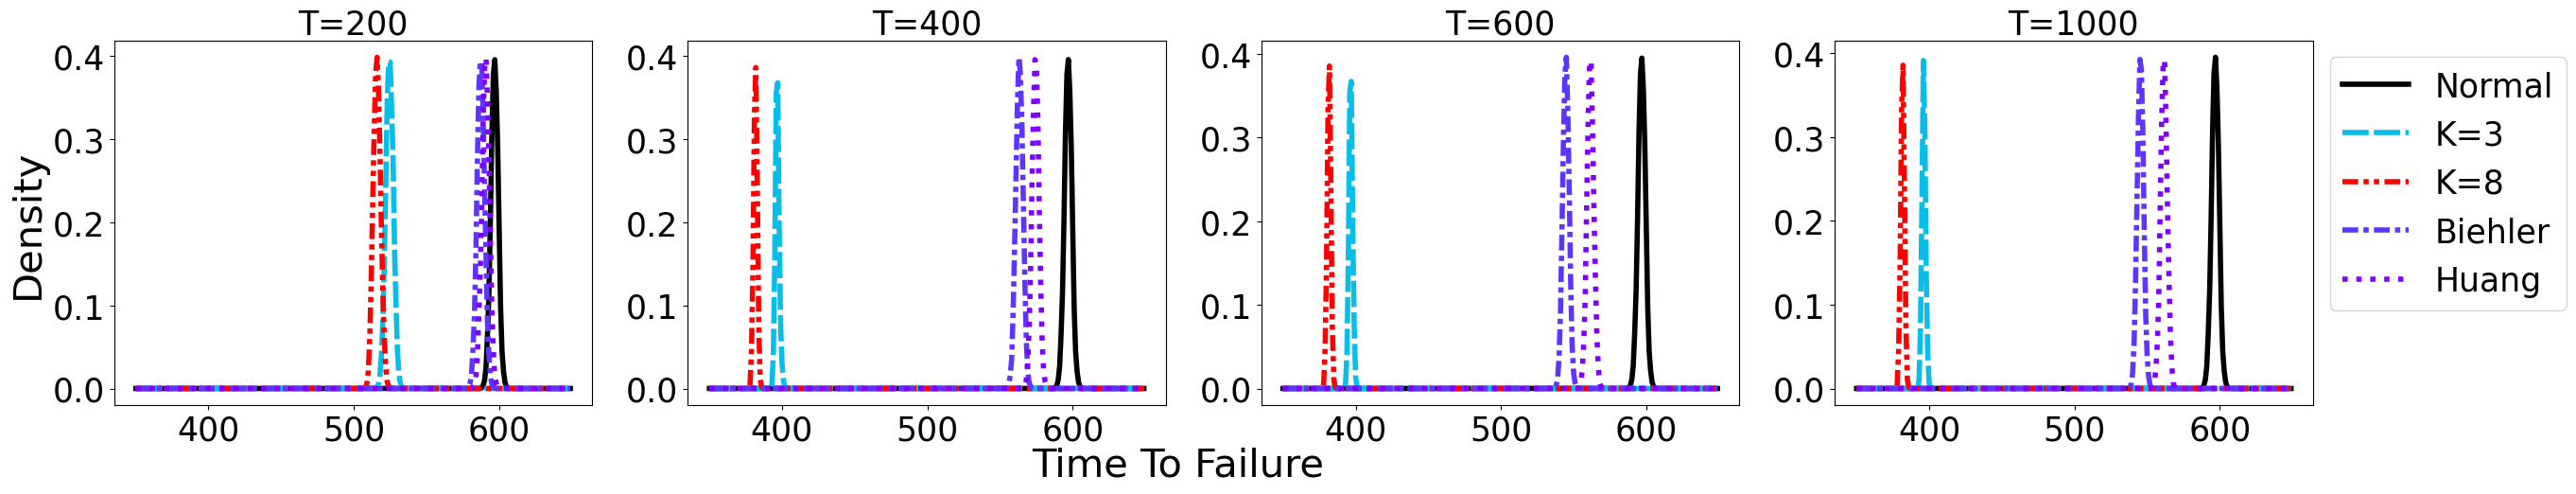

In [32]:
color = cm.rainbow(np.linspace(0, 1, 2*(no_controllers+no_sensors)))
linestyle = ['dotted',
             (0, (3, 1, 1, 1)),
             (5, (10, 3)),
             (0, (5, 1)),
             'dashdot',
             'dashed',
             (0, (3, 10, 1, 10, 1, 10)),
             (0, (3, 5, 1, 5)),
             (0, (3, 1, 1, 1, 1, 1))]
fig, axs = plt.subplots(nrows=1, ncols=len(T), figsize=(30,5))
axs[0].annotate('T=200', xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=25, ha='center', va='baseline')
axs[1].annotate('T=400', xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=25, ha='center', va='baseline')
axs[2].annotate('T=600', xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=25, ha='center', va='baseline')
axs[3].annotate('T=1000', xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=25, ha='center', va='baseline')
x_ax = np.arange(350,650)
for i in range(len(T)):
    axs[i].plot(x_ax, f_sim[350:650], label='Normal', color='black', lw=4)
    for k in [3, 8]:
        axs[i].plot(x_ax, f_opt[f'k{k}',T[i]][350:650], 
                    color=color[(no_controllers+no_sensors)-k-1], linestyle=linestyle[k],
                    label=f'K={k}', lw=4)
    axs[i].plot(x_ax, f_optb[T[i]][350:650], 
                color=color[1], linestyle=linestyle[1],
                label='Biehler', lw=4)
    axs[i].plot(x_ax, f_opth[T[i]][350:650], 
                color=color[0], linestyle=linestyle[0],
                label='Huang', lw=4)
    axs[i].xaxis.set_tick_params(which='major', labelsize=25)
    axs[i].yaxis.set_tick_params(which='major', labelsize=25)
axs[0].set_ylabel("Density", fontsize=30)
axs[-1].legend(prop={'size': 25}, bbox_to_anchor=(1.001, 1))
fig.text(0.5, -0.04, "Time To Failure", fontsize=30, ha='center')
plt.savefig('./img/pdf_comp.pdf', 
            format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

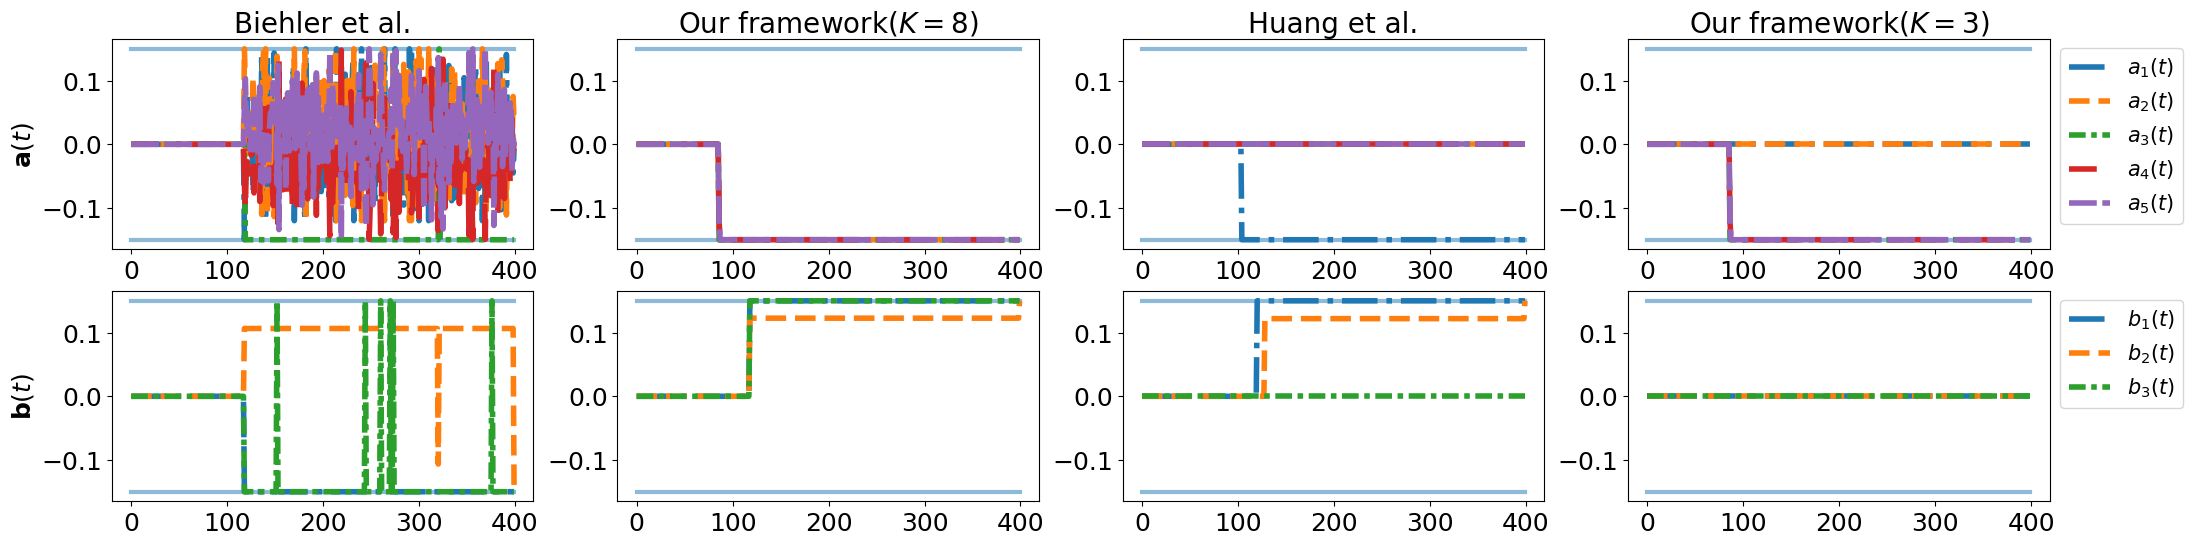

In [33]:
t = 400
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25,6))
for ax, col in zip(axs[0], ['Biehler et al.', "Our framework" + r"($K=8$)",
                            'Huang et al.', "Our framework" + r"($K=3$)"]):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                fontsize=20, ha='center', va='baseline')
x_ax = np.arange(t)
linestyle = ['dashdot',
             'dashed',
             (0, (3, 1, 1, 1)),
             (5, (10, 3)),
             (0, (5, 1)),
             (0, (3, 5, 1, 5)),
             (0, (3, 1, 1, 1, 1, 1)),
             'dotted',
             (0, (3, 10, 1, 10, 1, 10))]
k = 0
for s in ['b', 'k8', 'h', 'k3']:
    axs[0,k].plot(x_ax, [lb_a]*t, color='tab:blue', linestyle='-', linewidth=3, alpha=0.5)
    axs[0,k].plot(x_ax, [ub_a]*t, color='tab:blue', linestyle='-', linewidth=3, alpha=0.5)
    j = 0
    for i in range(a[s,t].shape[0]):
        axs[0,k].plot(x_ax, np.squeeze(np.asarray(a[s,t][i,:])), 
                        label=r'$a_{}(t)$'.format(i+1), 
                        linestyle=linestyle[j],
                        linewidth=4)
        j += 1
    if k == 0:
        axs[0,k].set_ylabel(r"$\mathbf{a}(t)$", fontsize=18)
    axs[0,k].tick_params(axis='both', which='major', labelsize=18)
    
    axs[1,k].plot(x_ax, [lb_b]*t, color='tab:blue', linestyle='-', linewidth=3, alpha=0.5)
    axs[1,k].plot(x_ax, [ub_b]*t, color='tab:blue', linestyle='-', linewidth=3, alpha=0.5)
    j = 0
    for i in range(b[s,t].shape[0]):
        axs[1,k].plot(x_ax, np.squeeze(np.asarray(b[s,t][i,:])), 
                        label=r'$b_{}(t)$'.format(i+1), 
                        linestyle=linestyle[j],
                        linewidth=4)
        j += 1
    if k == 0:
        axs[1,k].set_ylabel(r"$\mathbf{b}(t)$", fontsize=18)
    axs[1,k].tick_params(axis='both', which='major', labelsize=18)
    k += 1
axs[0,3].legend(prop={'size': 15},bbox_to_anchor=(1.001, 1.01))
axs[1,3].legend(prop={'size': 15},bbox_to_anchor=(1.001, 1.01))
plt.savefig(f'./img/Actions-T{t}.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [34]:
s = System(physical_states, no_controllers, no_sensors, sim_inits, 'case')
s.simulate(sd_v, sd_w, 1000)
mtof_baseline = 0.0
for t in tqdm(range(1, 1000+1), 
                desc="Generating z values for simulation ... "):
    _z = z_tau(s.x, t, sd_s, lamb, kappa, gamma)
    mtof_baseline += norm.cdf(_z)
    

mtof, mtofb, mtofh = defaultdict(list), defaultdict(), defaultdict()
for k in tqdm(K, desc="Generating z values for worst-case attack ... "):
    for t in T:
        _x = x_os[f'k{k}',t]
        E = 0.0
        for tt in range(1, 1000+1):
            _z = z_tau(_x, tt, sd_s, lamb, kappa, gamma)
            E += norm.cdf(_z)
        mtof[k].append(E)
for t in tqdm(T, desc="Generating z values for Huang et al. and Biehler et al. ... "):
    _xb, _xh = x_osb[t], x_osh[t]
    Eb, Eh = 0.0, 0.0
    for tt in range(1, 1000+1):
        _zb = z_tau(_xb, tt, sd_s, lamb, kappa, gamma)
        Eb += norm.cdf(_zb)
        _zh = z_tau(_xh, tt, sd_s, lamb, kappa, gamma)
        Eh += norm.cdf(_zh)
    mtofb[t], mtofh[t] = Eb, Eh

Generating z values for worst-case attack ... : 100%|██████████| 3/3 [00:00<00:00,  6.13it/s]
Generating z values for Huang et al. and Biehler et al. ... : 100%|██████████| 4/4 [00:00<00:00, 12.94it/s]


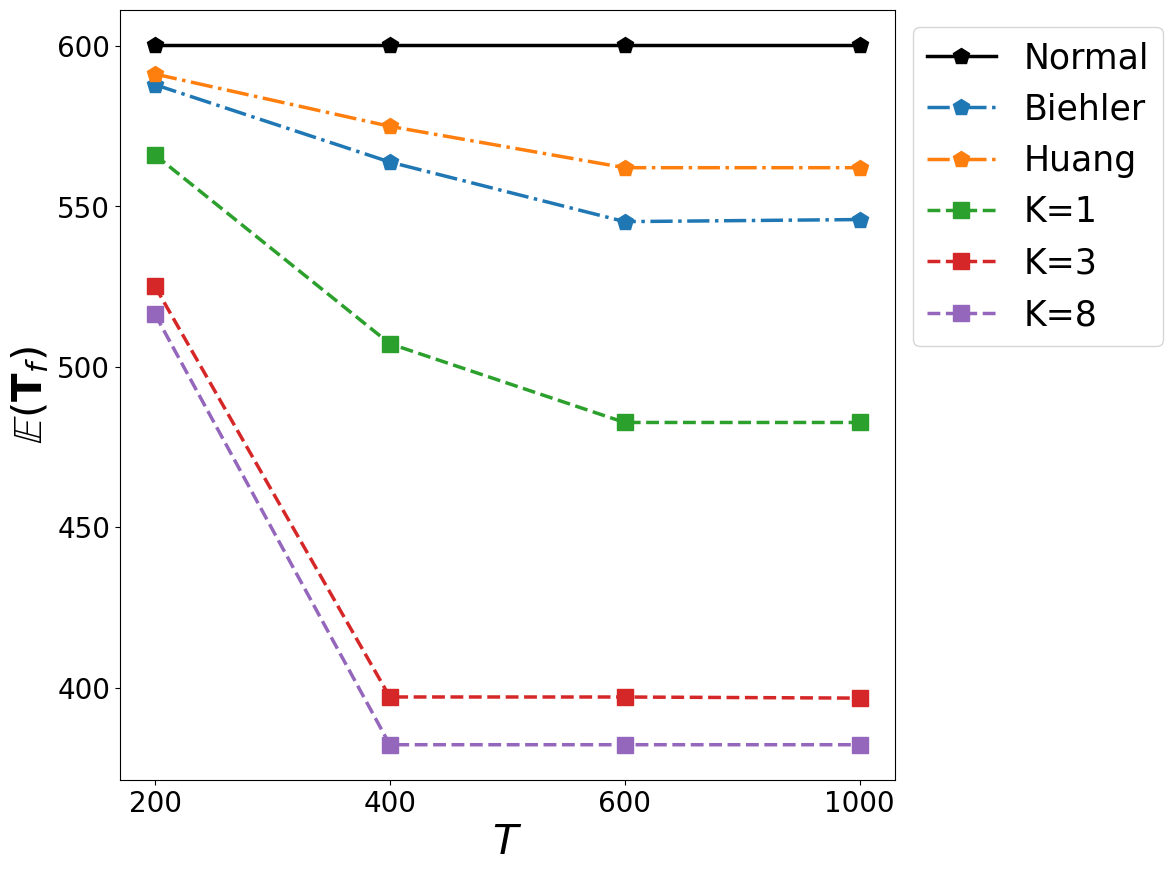

In [35]:
fig, ax = plt.subplots(1,figsize=(10,10))
j = 0
markers = ['p', 's', 'o', 'P', '*', 'h', '^', '+']
ax.plot([mtof_baseline]*len(T), marker=markers[j], markersize=12, 
        lw=2.5, color='k', label='Normal')
ax.plot(list(mtofb.values()), marker=markers[j], markersize=12, lw=2.5,
        linestyle=linestyle[j], label='Biehler')
ax.plot(list(mtofh.values()), marker=markers[j], markersize=12, lw=2.5,
        linestyle=linestyle[j], label='Huang')
for k in K:
    ax.plot(mtof[k], marker=markers[j+1], markersize=12, lw=2.5,
            linestyle=linestyle[j+1], label=f'K={k}')
ax.set_xticks(np.arange(len(mtofb.keys())))
ax.set_xticklabels(mtofb.keys(), ha='center', fontsize=20)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_xlabel(r'$T$', fontsize=30)
ax.set_ylabel(r'$\mathbb{E}(\mathbf{T}_{f})$', fontsize=30)
plt.legend(prop={'size': 25}, bbox_to_anchor=(1.001, 1.0))
plt.savefig('./img/mtof_comp.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()

In [39]:
Zref = defaultdict()
for t in T:
    Zref[t] = _read_matrix(f'Zref-{t}', 'case')
B = _read_matrix('B', 'case')
D = _read_matrix('D', 'case')

OBJ = defaultdict()
for s in ['k1', 'b', 'k8', 'h', 'k3']:
    for t in T:
        OBJ[s,t] = - np.sum(np.linalg.norm(Zref[t] - (D @ B @ b[s,t]) - a[s,t], ord=1, axis=0))
        
OBJ_baseline = []
for t in T:
    OBJ_baseline.append(
        - np.sum(np.linalg.norm(Zref[t], ord=1, axis=0))
        )
obj = defaultdict(list)
objh, objb = defaultdict(), defaultdict()
for k, v in OBJ.items():
    if k[0] == 'h':
        objh[k[1]] = v
    elif k[0] == 'b':
        objb[k[1]] = v
    else:
        obj[k[0]].append(v)

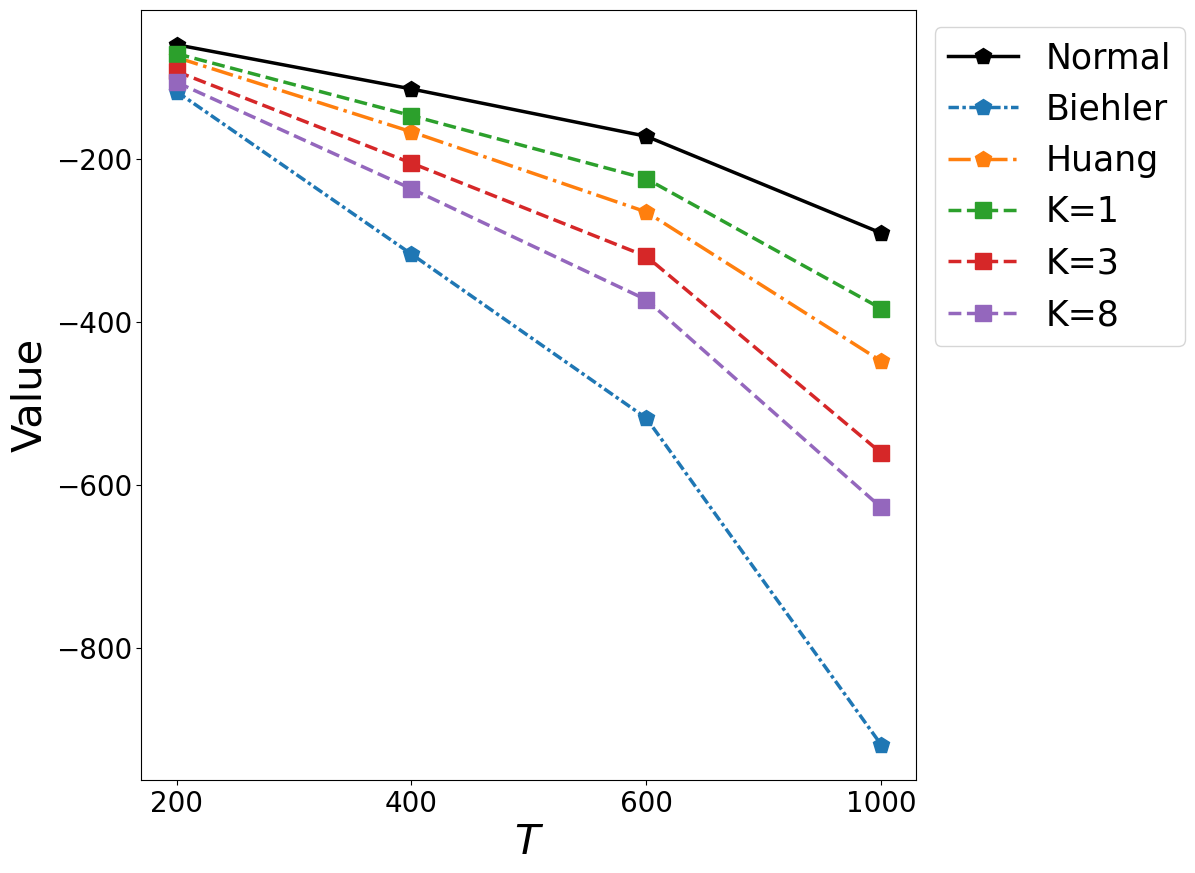

In [40]:
fig, ax = plt.subplots(1,figsize=(10,10))
j = 0
markers = ['p', 's', 'o', 'P', '*', 'h', '^', '+']
ax.plot(OBJ_baseline, marker=markers[j], markersize=12, 
        lw=2.5, color='k', label='Normal')
ax.plot(list(objb.values()), marker=markers[j], markersize=12, lw=2.5,
        linestyle=linestyle[j+2], label='Biehler')
ax.plot(list(objh.values()), marker=markers[j], markersize=12, lw=2.5,
        linestyle=linestyle[j], label='Huang')
for k in [1,3,8]:
    ax.plot(obj[f'k{k}'], marker=markers[j+1], markersize=12, lw=2.5,
            linestyle=linestyle[j+1], label=f'K={k}')
ax.set_xticks(np.arange(len(mtofb.keys())))
ax.set_xticklabels(objb.keys(), ha='center', fontsize=20)
ax.tick_params(axis='y', which='major', labelsize=20)
ax.set_xlabel(r'$T$', fontsize=30)
ax.set_ylabel('Value', fontsize=30)
plt.legend(prop={'size': 25}, bbox_to_anchor=(1.001, 1.0))
plt.savefig('./img/obj_comp.pdf', format='pdf', dpi=1200, bbox_inches='tight')
plt.show()